# One-Tailed Test: Asteroid Impacts

**Let's answer the question: What is the chance that within the next 1000 years a high-impact asteroid/meteorite (i.e., ≥ 1 km in diameter) will strike the planet?**

## Importing Libraries and Loading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Meteorite_Landings.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45428 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


In [4]:
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


## Investigating and Exploring Data

Given the varying numbers of non-null objects in the previous info, we should ensure that all columns we intend to work with contain sensible values and no null values.

**Dropping null values**

In [5]:
df2 = df.dropna(subset=['mass', 'year'])
df2 = df2[df2['mass'] > 0] # Zero mass also refers to missing data or null vaules

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45292 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45292 non-null  object 
 1   id           45292 non-null  int64  
 2   nametype     45292 non-null  object 
 3   recclass     45292 non-null  object 
 4   mass         45292 non-null  float64
 5   fall         45292 non-null  object 
 6   year         45292 non-null  float64
 7   reclat       38097 non-null  float64
 8   reclong      38097 non-null  float64
 9   GeoLocation  38097 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB


**Exploring data visually**

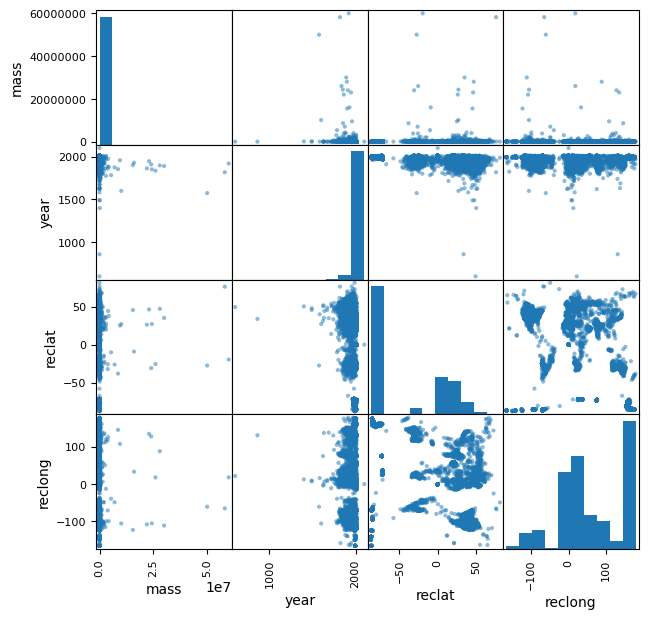

In [7]:
pd.plotting.scatter_matrix(df2[['mass', 'year', 'reclat', 'reclong']], figsize=(7,7));

We will see in the scatter plot above that this dataset captures only some meteorites, specifically those found in populated areas of the continents and not in oceans. Thus, a real analysis requires us to look at detection efficiency properly (i.e., the percentage of meteorites we successfully observe as a function of location on the planet). 

## Reducing data

**Pulling the 'year' and 'mass' columns out, converting mass into log-mass and creating histogram of log-mass**

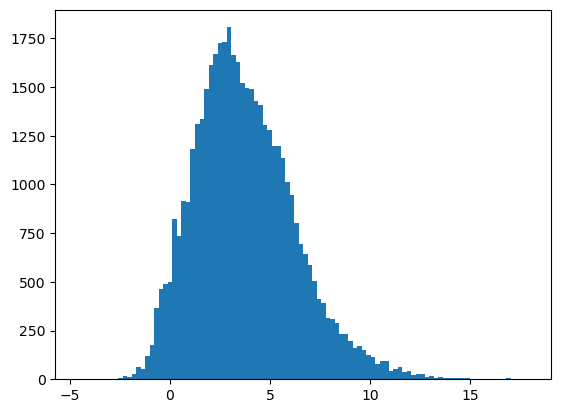

In [8]:
years = df2['year']
masses = df2['mass']
logmass = np.log(masses)
# Mass is a positive value that spans many orders of magnitude, so it's easier to look at logmass instead of mass itself.
plt.hist(logmass, bins=100);

**Creating a scatter plot of years vs counts**

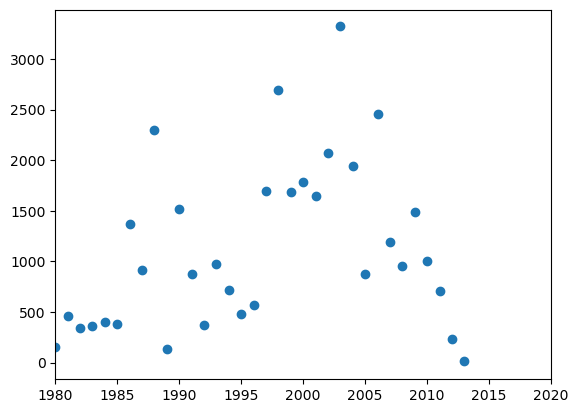

In [9]:
counts = years.value_counts() # This counts the number of meteorite impacts based on the years.
plt.scatter(counts.index, counts)
plt.xlim(1980, 2020); # We start from the year 1980 as we don't want to see all that crap back around the year zero.

## Defining Hypothesis (and Visualising)

What is the chance that within the next 1000 years a high-impact asteroid (i.e., ≥ 1 km in diameter) will strike the planet?

**Quantifying log-mass distribution** 

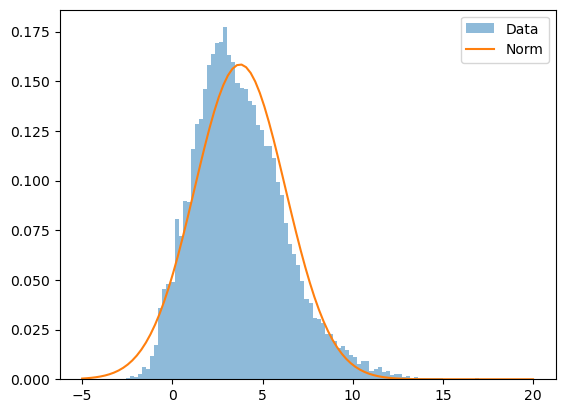

In [10]:
from scipy.stats import norm, lognorm, skewnorm
ms = np.linspace(-5, 20, 100) # ms = log-mass distribution that we sample

# Lets start with normal distribution
mean, std = np.mean(logmass), np.std(logmass)
pdf_norm = norm.pdf(ms, mean, std) 
# The pdf of normal distribution is calculated at the value of 'ms' evaluated with mean and std.
plt.hist(logmass, bins=100, density=True, alpha = 0.5, label='Data')
plt.plot(ms, pdf_norm, label= 'Norm')
plt.legend();

This normal distribution is not the best so lets try both a log-norm and a skew-norm.

C:\Users\rajen\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


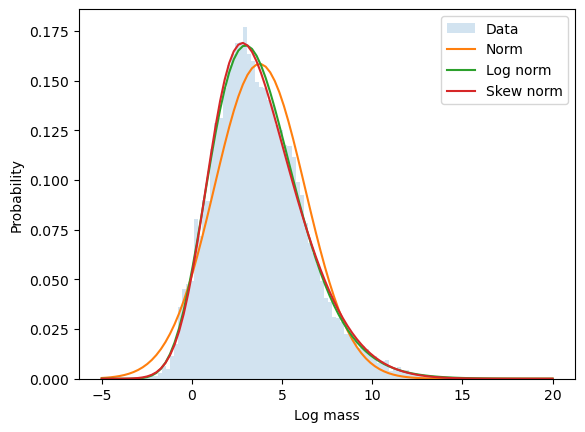

In [11]:
para_lognorm = lognorm.fit(logmass) # Fitting lognorm parameters on log mass data
pdf_lognorm = lognorm.pdf(ms, *para_lognorm)
# Here, an asterisk is used to declare a pointer that allows us to refer directly to fitted parameter values (i.e. p-lognorm in our case) in memory.
para_skewnorm = skewnorm.fit(logmass)
pdf_skewnorm = skewnorm.pdf(ms, *para_skewnorm)
plt.hist(logmass, bins=100, density=True, alpha = 0.2, label='Data')

plt.plot(ms, pdf_norm, label='Norm')
plt.plot(ms, pdf_lognorm, label='Log norm')
plt.plot(ms, pdf_skewnorm, label='Skew norm')
plt.xlabel('Log mass')
plt.ylabel('Probability')
plt.legend();

So either the log-norm or skew-norm looks like an adequate fit to the data. Now we continue with the **log-normal distribution**.

**Calculating the threshold mass (i.e. log mass_of_doom of the 1 km diameter meteorite) that we are concerned about**

In [12]:
mass_of_doom = np.log((4/3) * np.pi * 500**3 * 1600 * 1000)    
# Calculated using a spherical approximation (i.e. V = 4/3 * pi * r3) and some avgerage density of asteroids (i.e. D = 1600 kg/m3)
# Value of r is 500m (r = D/2) for 1 km diameter
mass_of_doom 

34.36175044077777

Now we have the threshold mass (= 34 log mass) and we quantify the probability that any given meteorite has a mass equal to or greater than this threshold for impacting the Earth.

**Calculating the log probability of an asteroid being equal to or above the threshold mass for hitting the Earth**

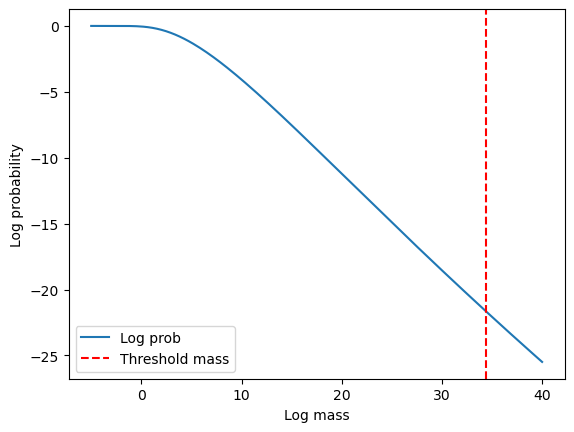

In [13]:
ms2 = np.linspace(-5, 40, 200) # Creating a new logmass data with increased data size to fit threshold mass in the data range
plt.plot(ms2, lognorm.logsf(ms2, *para_lognorm), label='Log prob')
plt.axvline(mass_of_doom, ls="--", color='red', label='Threshold mass') # Here, mass_of_doom refers to threshold mass.
plt.xlabel("Log mass")
plt.ylabel("Log probability")
plt.legend();

## Calculating P-Value and Visualising

**What is the probability that one or more asteroids of the given threshold mass or more strike the Earth in the next 1000 years?**

We assume that in the next 1000 years, we predict to have  𝑁 impacts (i.e. number of events).
 
𝑃(>=1 highmass)=1−𝑃(0 highmass)=1−𝑃(𝑁 not_highmass)=1−𝑃(not_highmass)^𝑁

We can imagine a similar question: What is the probability of getting no sixes in 5 rolls? This is given by:
5/6 * 5/6 * 5/6 * 5/6 * 5/6 = (5/6)^5

So to give a number, we need to calculate  𝑁  from the yearly rate, number of years, and our detection efficiency and use that with the probability that any given impact is not high mass.

Probability of a ≥ 1 km diameter asteroid impact on the Earth in the next 1000 years is 0.67%.


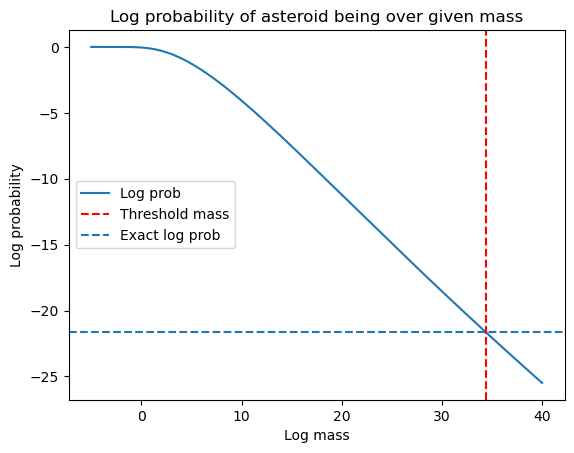

In [14]:
prob_small_mass = lognorm.logcdf(mass_of_doom, *para_lognorm)
frac_sky_monitored = 0.2 # We imagine that our telescope catches only 20% of asteroid events (with detection efficiency of 20%) 
num_years = 1000
num_events = num_years * counts.max() / frac_sky_monitored
prob_high_mass = 1 - np.exp(num_events * prob_small_mass) 
print(f'Probability of a ≥ 1 km diameter asteroid impact on the Earth in the next {num_years} years is {prob_high_mass * 100:.2f}%.')

ms2 = np.linspace(-5, 40, 200)
plt.plot(ms2, lognorm.logsf(ms2, *para_lognorm), label='Log prob')
plt.axvline(mass_of_doom, ls="--", color='red', label='Threshold mass')
exact_log_prob = lognorm.logsf(mass_of_doom, *para_lognorm)
plt.axhline(exact_log_prob, ls='--', label='Exact log prob') # Here, exact_log_prob means the exact log probability value at the mass_of_doom
plt.xlabel("Log mass")
plt.ylabel("Log probability")
plt.title("Log probability of asteroid being over given mass")
plt.legend();

Based on our probability value of 0.0067 quantified here, we can now say with 99.33% confidence (i.e., confidence level = 1 - α) that the high-impact asteroids will not strike the planet in the next 1000 years. 